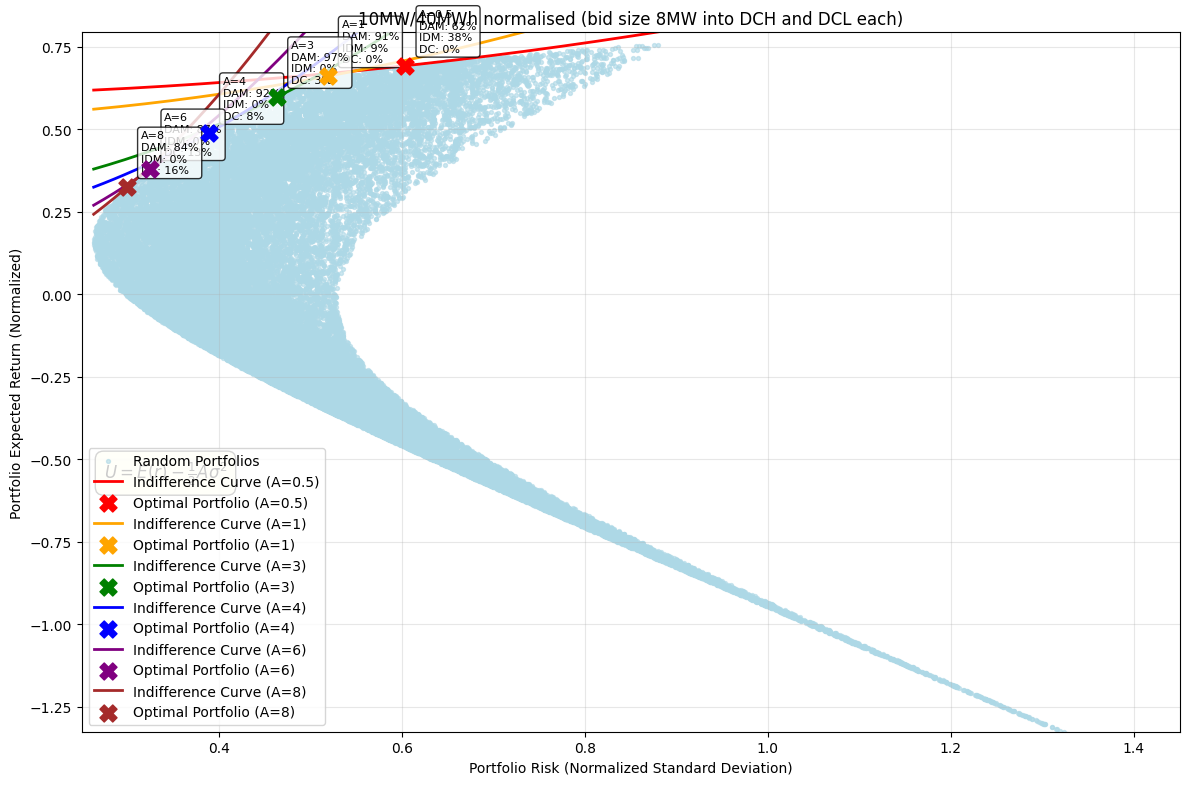

OPTIMAL PORTFOLIOS FOR DIFFERENT RISK AVERSIONS

Risk Aversion A = 0.5:
  DAM:      62.4%
  IDM:      37.6%
  DC:        0.0%
  Return (normalized):    0.692
  Risk (normalized):      0.604
  Return (original):    £1901.17
  Risk (original):      £1170.18

Risk Aversion A = 1:
  DAM:      90.8%
  IDM:       9.2%
  DC:        0.0%
  Return (normalized):    0.661
  Risk (normalized):      0.519
  Return (original):    £1884.58
  Risk (original):      £1137.86

Risk Aversion A = 3:
  DAM:      97.5%
  IDM:       0.0%
  DC:        2.5%
  Return (normalized):    0.598
  Risk (normalized):      0.464
  Return (original):    £1851.74
  Risk (original):      £1116.79

Risk Aversion A = 4:
  DAM:      92.2%
  IDM:       0.0%
  DC:        7.8%
  Return (normalized):    0.489
  Risk (normalized):      0.389
  Return (original):    £1794.80
  Risk (original):      £1088.42

Risk Aversion A = 6:
  DAM:      86.9%
  IDM:       0.0%
  DC:       13.1%
  Return (normalized):    0.379
  Risk (normalized

Using Config 1 (10MW/10MWh) base case data:
DAM: mean=£446.89, stdev=£312.07
IDM: mean=£472.66, stdev=£389.16
DC: mean=£797.87, stdev=£403.13
Correlations: DAM-IDM=0.665, DAM-DC=0.723, IDM-DC=0.476


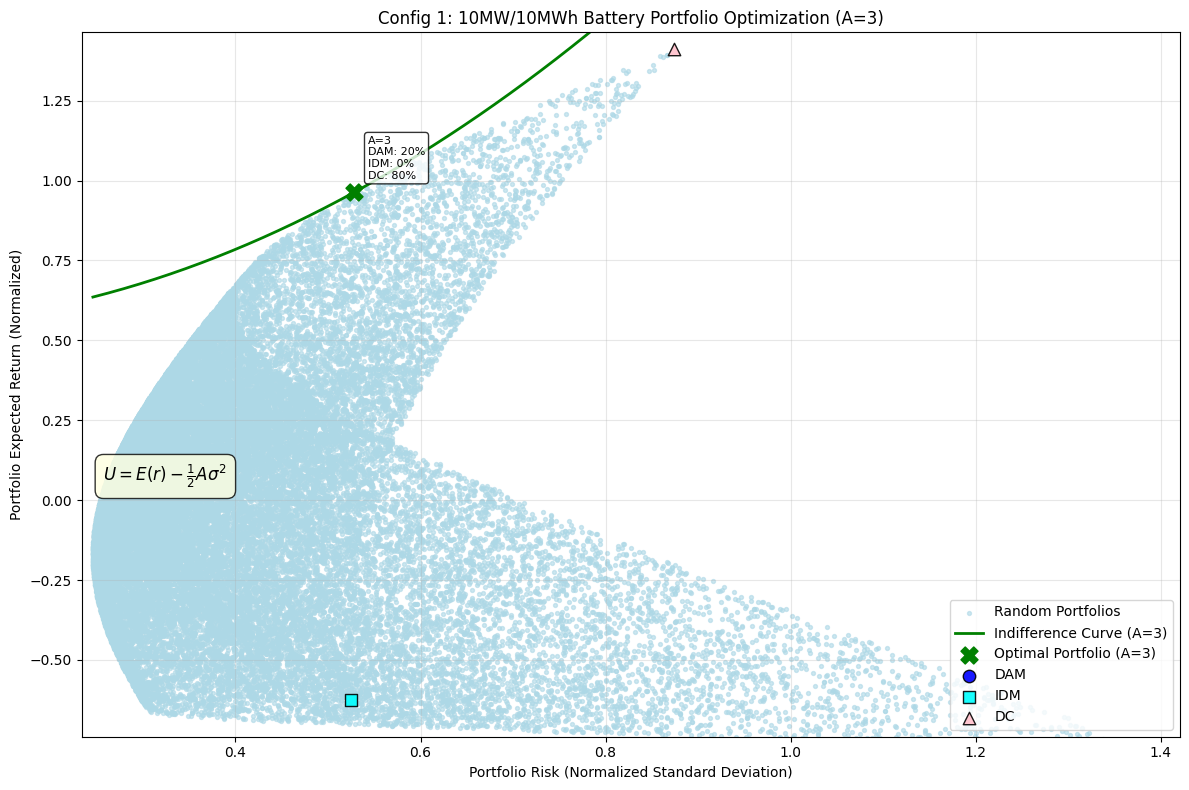


OPTIMAL PORTFOLIO FOR RISK AVERSION A=3

Optimal Portfolio Allocation:
  DAM:      20.4%
  IDM:       0.0%
  DC:       79.6%

Normalized Values:
  Return:    0.963
  Risk:      0.528

Original Scale:
  Expected Return: £ 726.27
  Portfolio Risk:  £ 389.26
  Utility (A=3):     0.545

GLOBAL MINIMUM VARIANCE PORTFOLIO:
  DAM:      26.3%
  IDM:      49.5%
  DC:       24.2%
  Return (normalized):   -0.174
  Risk (normalized):      0.246
  Expected Return: £ 544.65
  Portfolio Risk:  £ 377.97


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

# Load the CSV data
df = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Results EDA/Results for EDA/D*_price_addition_profit_stats.csv')

# Filter for Config 1 (10MW/10MWh = 1-hour battery) and base_case scenario
config_1_base = df[(df['config_id'] == 1) & (df['scenario'] == 'base_case')].iloc[0]

print("Using Config 1 (10MW/10MWh) base case data:")
print(f"DAM: mean=£{config_1_base['dam_mean']:.2f}, stdev=£{config_1_base['dam_std']:.2f}")
print(f"IDM: mean=£{config_1_base['idm_mean']:.2f}, stdev=£{config_1_base['idm_std']:.2f}")
print(f"DC: mean=£{config_1_base['dc_mean']:.2f}, stdev=£{config_1_base['dc_std']:.2f}")
print(f"Correlations: DAM-IDM={config_1_base['corr_dam_idm']:.3f}, DAM-DC={config_1_base['corr_dam_dc']:.3f}, IDM-DC={config_1_base['corr_idm_dc']:.3f}")

# Extract market data from CSV
returns_original = np.array([config_1_base['dam_mean'], config_1_base['idm_mean'], config_1_base['dc_mean']])
risks_original = np.array([config_1_base['dam_std'], config_1_base['idm_std'], config_1_base['dc_std']])

# Normalize returns and risks (mean=0, std=1)
returns = (returns_original - returns_original.mean()) / returns_original.std()
risks = (risks_original - risks_original.mean()) / risks_original.std()

# Build correlation matrix from CSV data
correlations = np.array([
    [1.000, config_1_base['corr_dam_idm'], config_1_base['corr_dam_dc']],
    [config_1_base['corr_dam_idm'], 1.000, config_1_base['corr_idm_dc']],
    [config_1_base['corr_dam_dc'], config_1_base['corr_idm_dc'], 1.000]
])

# Calculate covariance matrix with normalized data
cov_matrix = np.outer(risks, risks) * correlations

def calculate_portfolio_stats(weights):
    """Calculate return and risk for given weights"""
    portfolio_return = np.dot(weights, returns)
    portfolio_variance = np.dot(weights, np.dot(cov_matrix, weights))
    portfolio_risk = np.sqrt(portfolio_variance)
    return portfolio_return, portfolio_risk, portfolio_variance

def find_best_portfolio(risk_aversion):
    """Find portfolio that maximizes utility"""
    def objective_function(weights):
        port_return, _, port_variance = calculate_portfolio_stats(weights)
        utility = port_return - 0.5 * risk_aversion * port_variance
        return -utility
    
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 1), (0, 1), (0, 1)]
    
    result = minimize(objective_function, x0=[1/3, 1/3, 1/3], bounds=bounds, constraints=constraints)
    best_weights = result.x
    best_return, best_risk, best_variance = calculate_portfolio_stats(best_weights)
    
    return best_weights, best_return, best_risk

def generate_random_portfolios(num_portfolios=40000):
    """Generate random portfolios for plotting"""
    portfolios = []
    
    for i in range(num_portfolios):
        # Generate random weights
        weights = np.random.random(3)
        weights = weights / np.sum(weights)  # Make sure they sum to 1
        
        port_return, port_risk, _ = calculate_portfolio_stats(weights)
        portfolios.append([port_return, port_risk, weights[0], weights[1], weights[2]])
    
    df = pd.DataFrame(portfolios, columns=['Return', 'Risk', 'Weight_DAM', 'Weight_IDM', 'Weight_DC'])
    return df

# Generate portfolios for visualization
portfolio_data = generate_random_portfolios()

# Find minimum risk portfolio
min_risk_idx = portfolio_data['Risk'].idxmin()
min_risk_portfolio = portfolio_data.loc[min_risk_idx]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all random portfolios
ax.scatter(portfolio_data['Risk'], portfolio_data['Return'], 
          c='lightblue', alpha=0.6, s=8, label='Random Portfolios')

# Focus on A=3 only as requested
A = 3
weights, expected_return, risk = find_best_portfolio(A)
_, _, variance = calculate_portfolio_stats(weights)
opt_utility = expected_return - 0.5 * A * variance

# Create indifference curve: E[R] = U + 0.5*A*σ²
risk_range = np.linspace(portfolio_data['Risk'].min(), portfolio_data['Risk'].max(), 200)
variance_range = risk_range ** 2
indifference_curve = opt_utility + 0.5 * A * variance_range

# Plot indifference curve
ax.plot(risk_range, indifference_curve, 
        color='green', linestyle='-', linewidth=2, 
        label=f'Indifference Curve (A={A})')

# Add utility formula
ax.text(0.02, 0.35, r'$U = E(r) - \frac{1}{2}A\sigma^2$', 
        transform=ax.transAxes, fontsize=12, verticalalignment='bottom',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

# Plot optimal portfolio
ax.scatter(risk, expected_return, c='green', marker='X', s=150, 
          label=f'Optimal Portfolio (A={A})', zorder=5)

# Add annotation with market mix
annotation_text = f"A={A}\nDAM: {weights[0]:.0%}\nIDM: {weights[1]:.0%}\nDC: {weights[2]:.0%}"
ax.annotate(annotation_text, 
           xy=(risk, expected_return),
           xytext=(10, 10), textcoords='offset points',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
           fontsize=8, ha='left')

# Plot individual assets
asset_names = ['DAM', 'IDM', 'DC']
asset_colors = ['blue', 'cyan', 'pink']
asset_markers = ['o', 's', '^']

for i, (name, color, marker) in enumerate(zip(asset_names, asset_colors, asset_markers)):
    # Individual asset has 100% weight in that asset, 0% in others
    asset_weights = np.zeros(3)
    asset_weights[i] = 1.0
    asset_return, asset_risk, _ = calculate_portfolio_stats(asset_weights)
    
    ax.scatter(asset_risk, asset_return, color=color, s=80, marker=marker, 
              alpha=0.9, edgecolors='black', zorder=8, linewidth=1, label=name)

# Set reasonable axis limits to focus on the data
ax.set_xlim(portfolio_data['Risk'].min() * 0.95, portfolio_data['Risk'].max() * 1.05)
ax.set_ylim(portfolio_data['Return'].min() * 0.95, portfolio_data['Return'].max() * 1.05)

# Format the plot
ax.set_xlabel('Portfolio Risk (Normalized Standard Deviation)')
ax.set_ylabel('Portfolio Expected Return (Normalized)')
ax.set_title('Config 1: 10MW/10MWh Battery Portfolio Optimization (A=3)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print results with both normalized and original values
print("\n" + "="*60)
print("OPTIMAL PORTFOLIO FOR RISK AVERSION A=3")
print("="*60)

# Convert back to original scale for interpretation
original_return = expected_return * returns_original.std() + returns_original.mean()
original_risk = risk * risks_original.std() + risks_original.mean()

print(f"\nOptimal Portfolio Allocation:")
print(f"  DAM:     {weights[0]:6.1%}")
print(f"  IDM:     {weights[1]:6.1%}")
print(f"  DC:      {weights[2]:6.1%}")
print(f"\nNormalized Values:")
print(f"  Return:  {expected_return:7.3f}")
print(f"  Risk:    {risk:7.3f}")
print(f"\nOriginal Scale:")
print(f"  Expected Return: £{original_return:7.2f}")
print(f"  Portfolio Risk:  £{original_risk:7.2f}")
print(f"  Utility (A=3):   {opt_utility:7.3f}")

print(f"\nGLOBAL MINIMUM VARIANCE PORTFOLIO:")
print(f"  DAM:     {min_risk_portfolio['Weight_DAM']:6.1%}")
print(f"  IDM:     {min_risk_portfolio['Weight_IDM']:6.1%}")
print(f"  DC:      {min_risk_portfolio['Weight_DC']:6.1%}")
print(f"  Return (normalized):  {min_risk_portfolio['Return']:7.3f}")
print(f"  Risk (normalized):    {min_risk_portfolio['Risk']:7.3f}")

# Convert min risk portfolio to original scale
min_risk_original_return = min_risk_portfolio['Return'] * returns_original.std() + returns_original.mean()
min_risk_original_risk = min_risk_portfolio['Risk'] * risks_original.std() + risks_original.mean()
print(f"  Expected Return: £{min_risk_original_return:7.2f}")
print(f"  Portfolio Risk:  £{min_risk_original_risk:7.2f}")

Using Config 1 (10MW/10MWh) base case data:
DAM: mean=£446.89, stdev=£312.07
IDM: mean=£472.66, stdev=£389.16
DC: mean=£797.87, stdev=£403.13
Correlations: DAM-IDM=0.665, DAM-DC=0.723, IDM-DC=0.476


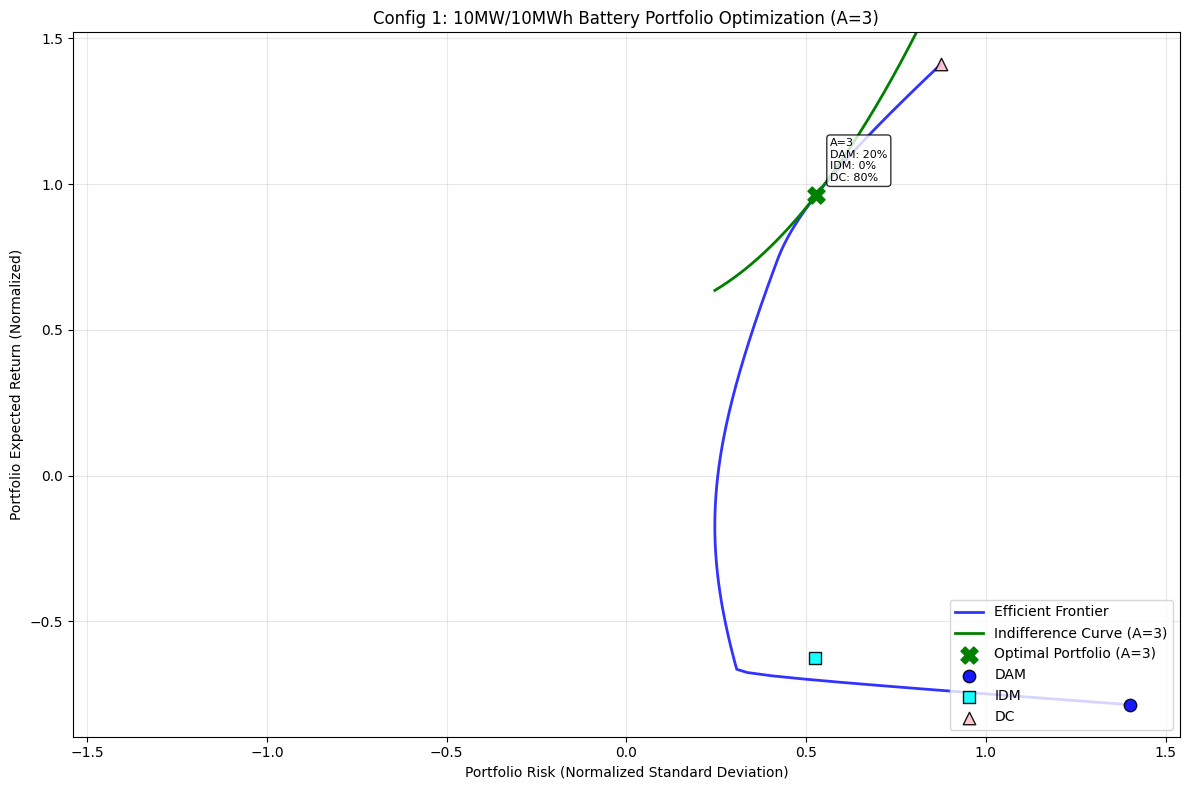


OPTIMAL PORTFOLIO FOR RISK AVERSION A=3

Optimal Portfolio Allocation:
  DAM:      20.4%
  IDM:       0.0%
  DC:       79.6%

Normalized Values:
  Return:    0.963
  Risk:      0.528

Original Scale:
  Expected Return: £ 726.27
  Portfolio Risk:  £ 389.26
  Utility (A=3):     0.545

GLOBAL MINIMUM VARIANCE PORTFOLIO:
  Return (normalized):   -0.168
  Risk (normalized):      0.246
  Expected Return: £ 545.66
  Portfolio Risk:  £ 377.97


Using Config 1 (10MW/10MWh) base case data:
DAM: mean=£446.89, stdev=£312.07
IDM: mean=£472.66, stdev=£389.16
DC: mean=£797.87, stdev=£403.13


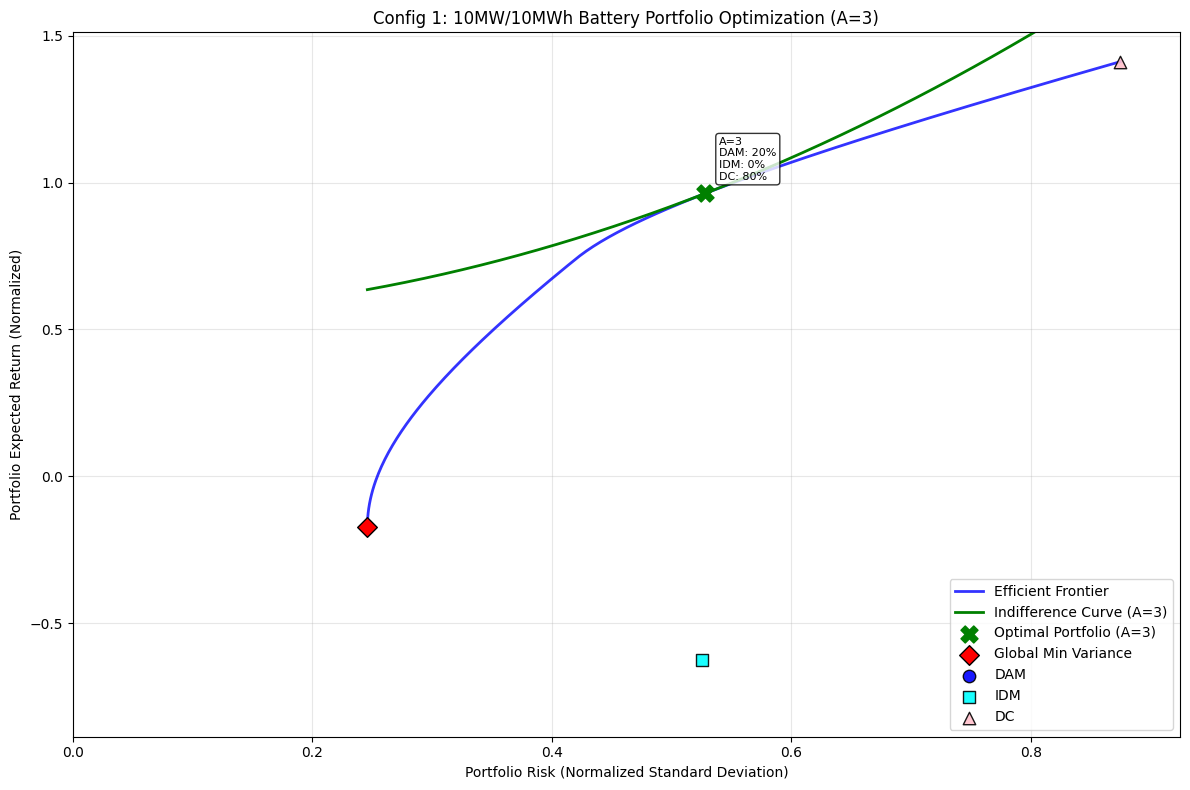


OPTIMAL PORTFOLIO FOR RISK AVERSION A=3

Optimal Portfolio Allocation:
  DAM:      20.4%
  IDM:       0.0%
  DC:       79.6%

Normalized Values:
  Return:    0.963
  Risk:      0.528

Original Scale:
  Expected Return: £ 726.27
  Portfolio Risk:  £ 389.26
  Utility (A=3):     0.545

GLOBAL MINIMUM VARIANCE PORTFOLIO:
  DAM:      26.4%
  IDM:      49.4%
  DC:       24.3%
  Return (normalized):   -0.173
  Risk (normalized):      0.246
  Expected Return: £ 544.84
  Portfolio Risk:  £ 377.97


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

# Load the CSV data
df = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Results EDA/Results for EDA/D*_price_addition_profit_stats.csv')

# Filter for Config 1 (10MW/10MWh = 1-hour battery) and base_case scenario
config_1_base = df[(df['config_id'] == 1) & (df['scenario'] == 'base_case')].iloc[0]

print("Using Config 1 (10MW/10MWh) base case data:")
print(f"DAM: mean=£{config_1_base['dam_mean']:.2f}, stdev=£{config_1_base['dam_std']:.2f}")
print(f"IDM: mean=£{config_1_base['idm_mean']:.2f}, stdev=£{config_1_base['idm_std']:.2f}")
print(f"DC: mean=£{config_1_base['dc_mean']:.2f}, stdev=£{config_1_base['dc_std']:.2f}")

# Extract market data from CSV
returns_original = np.array([config_1_base['dam_mean'], config_1_base['idm_mean'], config_1_base['dc_mean']])
risks_original = np.array([config_1_base['dam_std'], config_1_base['idm_std'], config_1_base['dc_std']])

# Normalize returns and risks (mean=0, std=1)
returns = (returns_original - returns_original.mean()) / returns_original.std()
risks = (risks_original - risks_original.mean()) / risks_original.std()

# Build correlation matrix from CSV data
correlations = np.array([
    [1.000, config_1_base['corr_dam_idm'], config_1_base['corr_dam_dc']],
    [config_1_base['corr_dam_idm'], 1.000, config_1_base['corr_idm_dc']],
    [config_1_base['corr_dam_dc'], config_1_base['corr_idm_dc'], 1.000]
])

# Calculate covariance matrix with normalized data
cov_matrix = np.outer(risks, risks) * correlations

def calculate_portfolio_stats(weights):
    """Calculate return and risk for given weights"""
    portfolio_return = np.dot(weights, returns)
    portfolio_variance = np.dot(weights, np.dot(cov_matrix, weights))
    portfolio_risk = np.sqrt(portfolio_variance)
    return portfolio_return, portfolio_risk, portfolio_variance

def find_best_portfolio(risk_aversion):
    """Find portfolio that maximizes utility"""
    def objective_function(weights):
        port_return, _, port_variance = calculate_portfolio_stats(weights)
        utility = port_return - 0.5 * risk_aversion * port_variance
        return -utility
    
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 1), (0, 1), (0, 1)]
    
    result = minimize(objective_function, x0=[1/3, 1/3, 1/3], bounds=bounds, constraints=constraints)
    best_weights = result.x
    best_return, best_risk, best_variance = calculate_portfolio_stats(best_weights)
    
    return best_weights, best_return, best_risk

def find_minimum_variance_portfolio():
    """Find the global minimum variance portfolio"""
    def objective(weights):
        return np.dot(weights, np.dot(cov_matrix, weights))
    
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 1), (0, 1), (0, 1)]
    
    result = minimize(objective, x0=[1/3, 1/3, 1/3], bounds=bounds, constraints=constraints)
    
    if result.success:
        weights = result.x
        portfolio_return = np.dot(weights, returns)
        portfolio_risk = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))
        return weights, portfolio_return, portfolio_risk
    return None

def generate_efficient_frontier(n_portfolios=200):
    """Generate efficient frontier starting from minimum variance portfolio"""
    # First find the minimum variance portfolio
    min_var_result = find_minimum_variance_portfolio()
    if min_var_result is None:
        return np.array([])
    
    _, min_return, min_risk = min_var_result
    
    # Set target returns from minimum variance return to maximum possible return
    max_ret = max(returns)
    
    # Only generate portfolios above the minimum variance point
    target_returns = np.linspace(min_return, max_ret, n_portfolios)
    efficient_portfolios = []
    
    for target_return in target_returns:
        # Minimize portfolio variance for target return
        def objective(weights):
            return np.dot(weights, np.dot(cov_matrix, weights))
        
        # Constraints: weights sum to 1, target return achieved
        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: np.dot(w, returns) - target_return}
        ]
        
        # Bounds: long only
        bounds = [(0, 1), (0, 1), (0, 1)]
        
        # Optimize
        result = minimize(objective, x0=[1/3, 1/3, 1/3],
                        bounds=bounds, constraints=constraints, method='SLSQP')
        
        if result.success:
            weights = result.x
            portfolio_return = np.dot(weights, returns)
            portfolio_risk = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))
            efficient_portfolios.append([portfolio_return, portfolio_risk])
    
    return np.array(efficient_portfolios)

# Generate efficient frontier
efficient_frontier = generate_efficient_frontier(200)

# Find minimum variance portfolio
min_var_weights, min_var_return, min_var_risk = find_minimum_variance_portfolio()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot efficient frontier
if len(efficient_frontier) > 0:
    ax.plot(efficient_frontier[:, 1], efficient_frontier[:, 0], 
            'b-', linewidth=2, alpha=0.8, label='Efficient Frontier')

# Focus on A=3
A = 3
weights, expected_return, risk = find_best_portfolio(A)
_, _, variance = calculate_portfolio_stats(weights)
opt_utility = expected_return - 0.5 * A * variance

# Create indifference curve: E[R] = U + 0.5*A*σ²
if len(efficient_frontier) > 0:
    risk_min = min(efficient_frontier[:, 1])
    risk_max = max(efficient_frontier[:, 1])
else:
    risk_min, risk_max = 0, 1

risk_range = np.linspace(risk_min, risk_max, 200)
variance_range = risk_range ** 2
indifference_curve = opt_utility + 0.5 * A * variance_range

# Plot indifference curve
ax.plot(risk_range, indifference_curve, 
        color='green', linestyle='-', linewidth=2, 
        label=f'Indifference Curve (A={A})')

# Plot optimal portfolio
ax.scatter(risk, expected_return, c='green', marker='X', s=150, 
          label=f'Optimal Portfolio (A={A})', zorder=5)

# Plot minimum variance portfolio
ax.scatter(min_var_risk, min_var_return, c='red', marker='D', s=100,
          label='Global Min Variance', zorder=5, edgecolors='black')

# Add annotation with market mix
annotation_text = f"A={A}\nDAM: {weights[0]:.0%}\nIDM: {weights[1]:.0%}\nDC: {weights[2]:.0%}"
ax.annotate(annotation_text, 
           xy=(risk, expected_return),
           xytext=(10, 10), textcoords='offset points',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
           fontsize=8, ha='left')

# Plot individual assets
asset_names = ['DAM', 'IDM', 'DC']
asset_colors = ['blue', 'cyan', 'pink']
asset_markers = ['o', 's', '^']

for i, (name, color, marker) in enumerate(zip(asset_names, asset_colors, asset_markers)):
    # Individual asset has 100% weight in that asset, 0% in others
    asset_weights = np.zeros(3)
    asset_weights[i] = 1.0
    asset_return, asset_risk, _ = calculate_portfolio_stats(asset_weights)
    
    ax.scatter(asset_risk, asset_return, color=color, s=80, marker=marker, 
              alpha=0.9, edgecolors='black', zorder=8, linewidth=1, label=name)

# Set axis limits to avoid negative risk values
if len(efficient_frontier) > 0:
    all_risks = list(efficient_frontier[:, 1]) + [risks[i] for i in range(len(risks))] + [min_var_risk, risk]
    all_returns = list(efficient_frontier[:, 0]) + [returns[i] for i in range(len(returns))] + [min_var_return, expected_return]
    
    # Ensure minimum risk is at least 0 or slightly positive
    risk_min = max(0, min(all_risks) - 0.05)
    risk_max = max(all_risks) + 0.05
    return_min = min(all_returns) - 0.1
    return_max = max(all_returns) + 0.1
    
    ax.set_xlim(risk_min, risk_max)
    ax.set_ylim(return_min, return_max)

# Format the plot
ax.set_xlabel('Portfolio Risk (Normalized Standard Deviation)')
ax.set_ylabel('Portfolio Expected Return (Normalized)')
ax.set_title('Config 1: 10MW/10MWh Battery Portfolio Optimization (A=3)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print results
print("\n" + "="*60)
print("OPTIMAL PORTFOLIO FOR RISK AVERSION A=3")
print("="*60)

# Convert back to original scale for interpretation
original_return = expected_return * returns_original.std() + returns_original.mean()
original_risk = risk * risks_original.std() + risks_original.mean()

print(f"\nOptimal Portfolio Allocation:")
print(f"  DAM:     {weights[0]:6.1%}")
print(f"  IDM:     {weights[1]:6.1%}")
print(f"  DC:      {weights[2]:6.1%}")
print(f"\nNormalized Values:")
print(f"  Return:  {expected_return:7.3f}")
print(f"  Risk:    {risk:7.3f}")
print(f"\nOriginal Scale:")
print(f"  Expected Return: £{original_return:7.2f}")
print(f"  Portfolio Risk:  £{original_risk:7.2f}")
print(f"  Utility (A=3):   {opt_utility:7.3f}")

print(f"\nGLOBAL MINIMUM VARIANCE PORTFOLIO:")
print(f"  DAM:     {min_var_weights[0]:6.1%}")
print(f"  IDM:     {min_var_weights[1]:6.1%}")
print(f"  DC:      {min_var_weights[2]:6.1%}")
print(f"  Return (normalized):  {min_var_return:7.3f}")
print(f"  Risk (normalized):    {min_var_risk:7.3f}")

# Convert min variance portfolio to original scale
min_var_original_return = min_var_return * returns_original.std() + returns_original.mean()
min_var_original_risk = min_var_risk * risks_original.std() + risks_original.mean()
print(f"  Expected Return: £{min_var_original_return:7.2f}")
print(f"  Portfolio Risk:  £{min_var_original_risk:7.2f}")

Config 1 scenarios available: 23
DC price scenarios: ['base_case', 'down_10%', 'down_15%', 'down_20%', 'down_25%', 'down_30%', 'down_35%', 'down_40%', 'down_45%', 'down_5%', 'down_50%', 'down_55%', 'down_60%', 'down_65%', 'down_70%', 'down_75%', 'down_80%', 'up_10%', 'up_15%', 'up_20%', 'up_25%', 'up_30%', 'up_5%']
✓ down_80% (-80%): frontier generated
✓ down_50% (-50%): frontier generated
✓ down_25% (-25%): frontier generated
✓ base_case (+0%): frontier generated
✓ up_25% (+25%): frontier generated


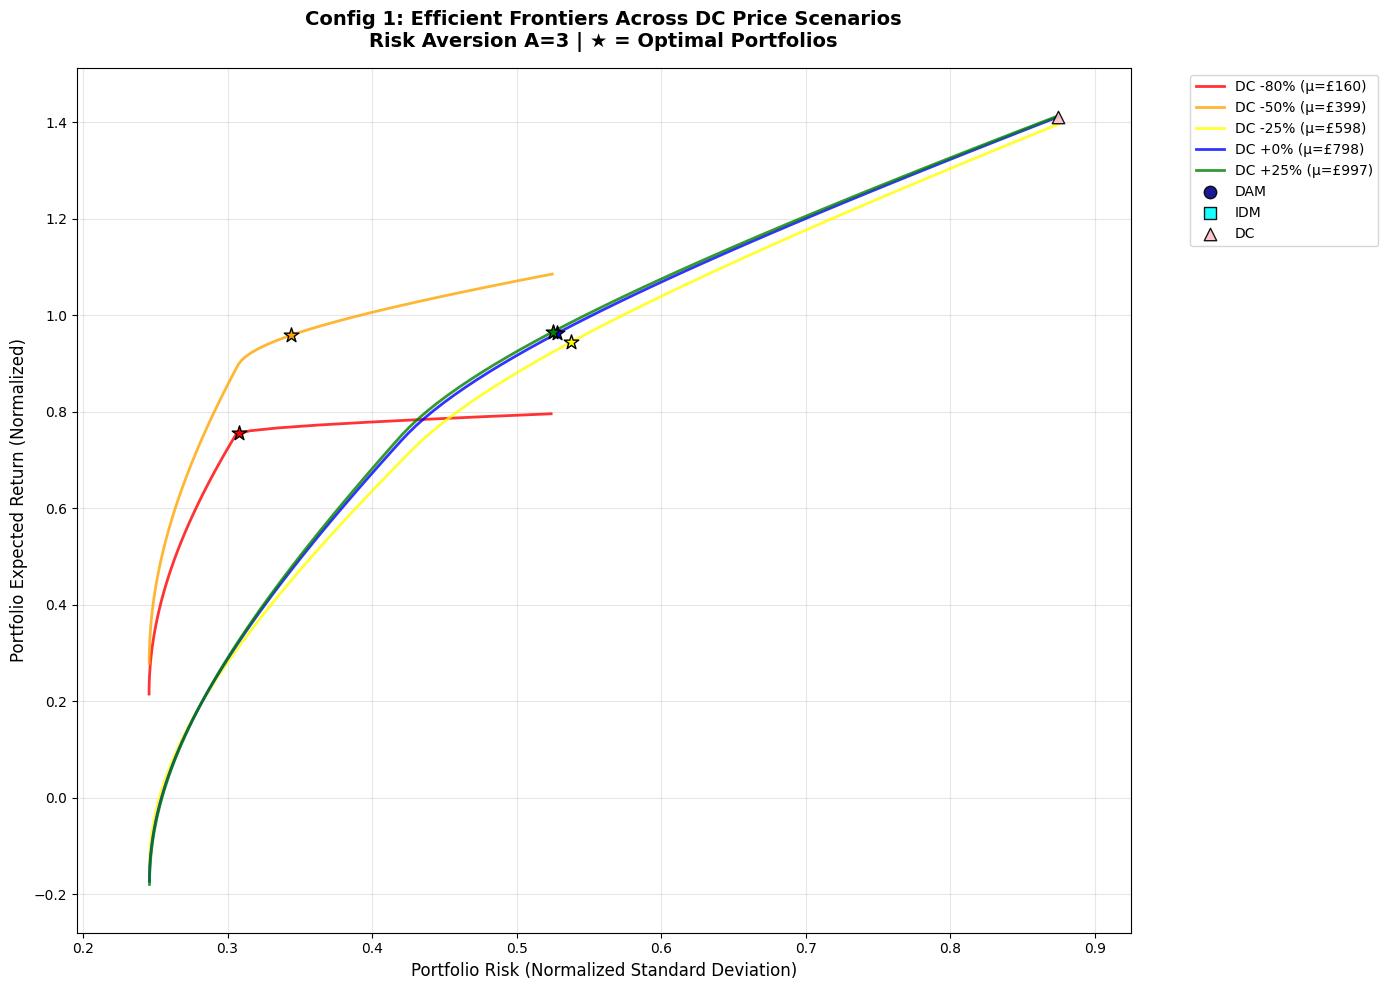


OPTIMAL PORTFOLIOS (A=3) ACROSS DC PRICE SCENARIOS

DOWN 80% (DC -80%):
  DAM:  21.9%  |  IDM:  78.1%  |  DC:   0.0%
  Expected Return: £   467  |  Risk: £   380  |  Utility:  0.61

DOWN 50% (DC -50%):
  DAM:  15.0%  |  IDM:  85.0%  |  DC:   0.0%
  Expected Return: £   469  |  Risk: £   382  |  Utility:  0.78

DOWN 25% (DC -25%):
  DAM:  19.7%  |  IDM:   0.0%  |  DC:  80.3%
  Expected Return: £   568  |  Risk: £   390  |  Utility:  0.51

BASE CASE (DC +0%):
  DAM:  20.4%  |  IDM:   0.0%  |  DC:  79.6%
  Expected Return: £   726  |  Risk: £   389  |  Utility:  0.54

UP 25% (DC +25%):
  DAM:  20.6%  |  IDM:   0.0%  |  DC:  79.4%
  Expected Return: £   884  |  Risk: £   389  |  Utility:  0.55

Total scenarios plotted: 5
★ Each star represents the optimal portfolio for A=3 under that DC price scenario


Config 1 scenarios available: 23
✓ down_80% (-80%)
✓ down_50% (-50%)
✓ down_25% (-25%)
✓ base_case (+0%)
✓ up_25% (+25%)


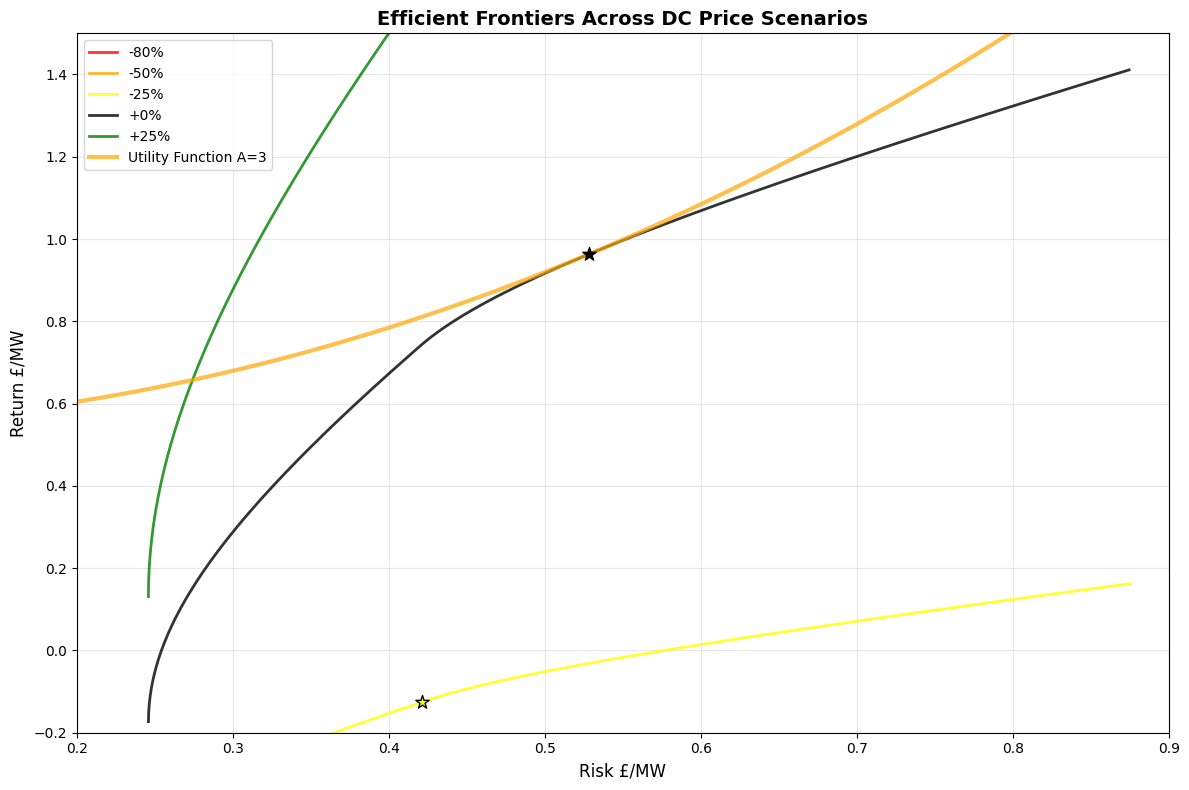


Total scenarios plotted: 5
down_80%: DC -80% - DAM:22.1% IDM:77.9% DC:0.0%
down_50%: DC -50% - DAM:22.1% IDM:77.9% DC:0.0%
down_25%: DC -25% - DAM:29.5% IDM:1.1% DC:69.4%
base_case: DC +0% - DAM:20.4% IDM:0.0% DC:79.6%
up_25%: DC +25% - DAM:11.1% IDM:0.0% DC:88.9%
